# Predicting Length-of-Stay at Hospitals (Project Notebook)
Author: Daniel Cummings   
Email: daniel.j.cummings@me.com   

The goal of this project is offer a predicted Length-of-Stay (LOS) for each patient at time of hospital admission. The inputs to the prediction model will include features such as patient’s diagnosis category (e.g. heart disease, delivery, injury/poisoning, etc.), age, gender, and race. 

## Table of Contents

1. [**Project Overview**](#Overview)
1.1 [Problem Statement](#Problem_statement)
1.2 [Metrics](#Metrics)
2. [**Data Exploration and Feature Engineering**](#Data-Exploration)   
2.1 [ADMISSIONS.csv](#ADMISSIONS.csv)   
2.1.1 [*Length-of-Stay (Feature Engineering)*](#LOS_FE)    
2.1.2 [*Deathtime*](#Deathtime)  
2.1.3 [*Ethnicity*](#Ethnicity)  
2.1.4 [*Religion*](#Religion)   
2.1.5 [*Admission Type*](#Adm_type)   
2.1.6 [*Insurance*](#Insurance)  
2.1.7 [*Marital Status*](#Marital)  
2.2 [DIAGNOSES_ICD.csv](#DIAGNOSES_ICD.csv)      
2.2.1 [ICD-9 Code (Feature Engineering)](#ICD_FE)   
2.3 [PATIENTS.csv](#PATIENTS.csv)     
2.3.1 [*Age (Feature Engineering)*](#Age_FE)   
2.3.2 [*Gender*](#Gender)   
2.4 [ICUSTAYS.csv](#ICUSTAYS.csv)  
2.4.1 [*ICU (Feature Engineering)*](#ICU_FE)  
3. [**Data Preprocessing**](#Data-Preprocessing)   
3.1 [Data Cleaning Function](#Data-cleanup)
4. [**Length-of-Stay Prediction Model**](#Prediction)   
4.1 [Model Implementation](#Implementation)  
4.2 [Model Refinement](#Refinement)      
5. [**Results**](#Results)
6. [**Conclusion**](#Conclusion)

<a class="anchor" id="Overview"></a>
## 1. Project Overview

Predictive analytics is an increasingly important tool in the healthcare field since modern machine learning (ML) methods can use large amounts of available data to predict individual outcomes for patients. For example, ML predictions can help healthcare providers determine likelihoods of disease, aid in diagnosis, recommend treatment, and predict future wellness. For this project, I chose to focus on a more logistical metric of healthcare, hospital length-of-stay (LOS). LOS is defined as the time between hospital admission and discharge measured in days.

U.S. hospital stays cost the health system at least $377.5 billion per year and recent Medicare legislation standardizes payments for procedures performed, regardless of the number of days a patient spends in the hospital. This incentivizes hospitals to identify patients of high LOS risk at the time of admission. Once identified, patients with high LOS risk can have their treatment plan optimized to minimize LOS and lower the chance of getting a hospital-acquired condition such as staph infection. Another benefit is that prior knowledge of LOS can aid in logistics such as room and bed allocation planning.

<a class="anchor" id="Problem_statement"></a>
### 1.1 Problem Statement

The goal of this project is to create a model that predicts the length-of-stay for each patient at time of admission. My first intuition was that the inputs to the prediction model should ideally include features such as patient’s diagnosis category (e.g. heart disease, delivery, injury/poisoning, etc.), age, gender, marital status, and race. After looking for a useful medical database, I ended up choosing the MIT MIMIC-III database due to the robust amount of information it held. MIMIC is described as the following [(source)](https://mimic.physionet.org/). “MIMIC is an openly available dataset developed by the MIT Lab for Computational Physiology, comprising de-identified health data associated with ~40,000 critical care patients. It includes demographics, vital signs, laboratory tests, medications, and more.” MIMIC is a relational database containing tables of data relating to patients who stayed within the intensive care units at Beth Israel Deaconess Medical Center in Boston, MA. 

As a side note, MIMIC-III requires taking a research ethics and compliance training [course]( https://about.citiprogram.org/en/homepage/) and filling out a research application form for MIMIC on https://physionet.org. Additionally, the database does not include pediatric information (ages 2-13). Due to the restrictive nature of the dataset, I will not be able to provide a copy in the GitHub repo associated with this notebook. 

<a class="anchor" id="Metrics"></a>
### 1.2 Metrics

The expected outcome of this project is to develop a model that will be better at predicting hospital LOS than the industry standards of median and average LOS. The median LOS is simply the median LOS of past admissions to a hospital. Similarly, a second commonly used metric in healthcare is the average, or mean LOS. To measure performance, I’ll compare the prediction model against the median and average LOS using the root-mean-square error (RMSE). The RMSE is a commonly used measure of the differences between values predicted by a model and the values observed, where a lower score implies better accuracy. For example, a perfect prediction model would have an RMSE of 0. The RMSE equation for this work is given as follows, where (n) is the number of hospital admission records, ($\hat{y}$) the prediction LOS, and (y) is the actual LOS.

<img src="images/RMSE.png"/>

The ultimate goal is to develop a prediction model that results in a lower RMSE than the average or median models. There is a multitude of regression models available for predicting LOS. To determine the best regression model for this work (of the subset of models that will be evaluated), the R2 (R-squared) score will be used. The R2 is a measure of the goodness of the fit of a model. In other words, it is the proportion of the variance in the dependent variable that is predictable from the independent variables. R2 is defined as the following equation where ($y_i$) is an observed data point, ($\hat{y}$) is the mean of the observed data, and ($f_i$) the predicted model value.

<img src="images/r2.png"/>

Best possible R2 score is 1.0 and a negative value means it is worse than a constant model, average or median in this case.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns

The following csv files were downloaded from the MIMIC-III database [source](https://mimic.physionet.org/).

In [2]:
# Primary Admissions information
df = pd.read_csv('data/ADMISSIONS.csv')

# Patient specific info such as gender
df_pat = pd.read_csv('data/PATIENTS.csv')

# Diagnosis for each admission to hospital
df_diagcode = pd.read_csv('data/DIAGNOSES_ICD.csv')

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_csv('data/ICUSTAYS.csv')

<a class="anchor" id="Data-Exploration"></a>
# 2. Data Exploration and Feature Engineering

In this section, I'll examine the various imported MIMIC DataFrames to understand how the data is distributed. Additionaly, I need to figure out a strategy to extract the target Length-of-Stay (LOS) values and understand what features (independent variables) may be useful in predicting LOS. 

**NOTE**: I have to perform a good amount of feature engineering in this section to enable the visualization of certain data categories. Any additional data 'tidyness' problems will be addressed in the 'Data Preprocessing' section including a comprehensive preprocessing function. 

<a class="anchor" id="ADMISSIONS.csv"></a>
## 2.1 ADMISSIONS.csv Exploration 

From [MIMIC](https://mimic.physionet.org/mimictables/admissions/): The ADMISSIONS table gives information regarding a patient’s admission to the hospital. Since each unique hospital visit for a patient is assigned a unique HADM_ID, the ADMISSIONS table can be considered as a definition table for HADM_ID. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
ROW_ID                  58976 non-null int64
SUBJECT_ID              58976 non-null int64
HADM_ID                 58976 non-null int64
ADMITTIME               58976 non-null object
DISCHTIME               58976 non-null object
DEATHTIME               5854 non-null object
ADMISSION_TYPE          58976 non-null object
ADMISSION_LOCATION      58976 non-null object
DISCHARGE_LOCATION      58976 non-null object
INSURANCE               58976 non-null object
LANGUAGE                33644 non-null object
RELIGION                58518 non-null object
MARITAL_STATUS          48848 non-null object
ETHNICITY               58976 non-null object
EDREGTIME               30877 non-null object
EDOUTTIME               30877 non-null object
DIAGNOSIS               58951 non-null object
HOSPITAL_EXPIRE_FLAG    58976 non-null int64
HAS_CHARTEVENTS_DATA    58976 non-null int64
dtypes: int64(5), objec

In [4]:
print('Dataset has {} number of unique admission events.'.format(df['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['SUBJECT_ID'].nunique()))

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.


<a class="anchor" id="LOS_FE"></a>
### 2.1.1 Length-of-Stay (Feature Engineering)

The first task is to figure out a way to calculate the LOS. LOS is defined as the time between admission and discharge from the hospital.

In [5]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [6]:
# Convert admission and discharge times to datatime type
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])

# Convert timedelta type into float 'days', 86400 seconds in a day
df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400

In [7]:
# Verify
df[['ADMITTIME', 'DISCHTIME', 'LOS']].head()

,ADMITTIME,DISCHTIME,LOS
0,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444
1,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528
2,2157-10-18 19:34:00,2157-10-25 14:00:00,6.768056
3,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944
4,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028


In [8]:
df['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [9]:
# Look at what is happening with negative LOS values
df[df['LOS'] < 0]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS
425,534,417,102633,2177-03-23 16:17:00,2177-03-23 07:20:00,2177-03-23 07:20:00,URGENT,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,NaN,NaN,ORGAN DONOR ACCOUNT,1,1,-0.372917
456,237,181,102631,2153-10-12 09:49:00,2153-10-12 06:29:00,2153-10-12 06:29:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,MARRIED,WHITE,2153-10-12 06:23:00,2153-10-12 07:45:00,DISSECTING ANEURYSIM,1,1,-0.138889
692,644,516,187482,2197-07-31 20:18:00,2197-07-31 01:10:00,2197-07-31 01:10:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,WIDOWED,UNKNOWN/NOT SPECIFIED,2197-07-31 11:31:00,2197-07-31 14:35:00,RESPIRATORY DISTRESS,1,0,-0.797222
1911,1640,1334,138015,2137-09-02 14:43:00,2137-09-02 12:00:00,2137-09-02 12:00:00,NEWBORN,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,NaN,WHITE,NaN,NaN,NEWBORN,1,1,-0.113194
1970,1699,1381,181430,2189-01-02 14:25:00,2189-01-02 12:00:00,2189-01-02 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,UNOBTAINABLE,MARRIED,WHITE,2189-01-02 10:31:00,2189-01-02 15:56:00,STROKE;TELEMETRY,1,1,-0.100694
2784,2935,2420,135098,2184-12-01 19:28:00,2184-12-01 16:50:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,2184-11-30 11:14:00,2184-12-01 03:00:00,ALTERED MENTAL STATUS,0,1,-0.109722
3342,3244,2677,108011,2128-04-16 12:28:00,2128-04-16 12:00:00,2128-04-16 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,NOT SPECIFIED,WIDOWED,WHITE,2128-04-16 03:23:00,2128-04-16 14:35:00,PANCREATITIS,1,1,-0.019444
3622,3447,2858,190088,2108-09-25 15:29:00,2108-09-25 12:00:00,2108-09-25 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,WIDOWED,WHITE,NaN,NaN,MYOCARDIAL INFARCTION\CATH,1,1,-0.145139
3996,3894,3229,161198,2134-11-30 18:19:00,2134-11-30 12:00:00,2134-11-30 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,UNOBTAINABLE,NaN,WHITE,2134-11-30 16:40:00,2134-11-30 19:07:00,HEAD BLEED,1,1,-0.263194
4445,4879,4023,170307,2153-05-27 11:14:00,2153-05-27 09:45:00,2153-05-27 09:45:00,EMERGENCY,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,NaN,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,NaN,NaN,ORGAN DONOR ACCOUNT,1,1,-0.061806


In [10]:
# Drop rows with negative LOS, usually related to a time of death before admission
df['LOS'][df['LOS'] > 0].describe()

count    58878.000000
mean        10.151266
std         12.459774
min          0.001389
25%          3.755556
50%          6.489583
75%         11.805556
max        294.660417
Name: LOS, dtype: float64

In [11]:
# Drop LOS < 0 
df = df[df['LOS'] > 0]

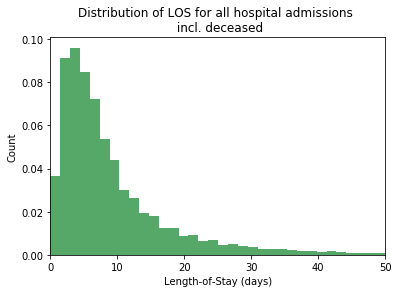

In [12]:
# Plot LOS Distribution
plt.hist(df['LOS'], bins=200, color = '#55a868',density=True)
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [13]:
# Pre-emptively drop some columns that I don't need anymore
df.drop(columns=['DISCHTIME', 'ROW_ID', 
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA'], inplace=True)

<a class="anchor" id="Deathtime"></a>
### 2.1.2 Deathtime

Patients who died at the hospital will later be **dropped** from the DataFrame as they would bias the LOS since they never were discharged 'alive' from the hospital. In other words, LOS would be shorter for this group. 

In [14]:
# Mark admissions where patients died in boolean column
df['DECEASED'] = df['DEATHTIME'].notnull().map({True:1, False:0})

In [15]:
print("{} of {} patients died in the hospital".format(df['DECEASED'].sum(), 
                                                     df['SUBJECT_ID'].nunique()))

5774 of 46445 patients died in the hospital


In [16]:
# Look at statistics less admissions resulting in death
df['LOS'].loc[df['DECEASED'] == 0].describe()

count    53104.000000
mean        10.138174
std         12.284461
min          0.014583
25%          3.866667
50%          6.565972
75%         11.711632
max        294.660417
Name: LOS, dtype: float64

In [17]:
# Hospital LOS metrics for later comparison
actual_mean_los = df['LOS'].loc[df['DECEASED'] == 0].mean() 
actual_median_los = df['LOS'].loc[df['DECEASED'] == 0].median() 

print(actual_mean_los)
print(actual_median_los)

10.138173704219758
6.565972222222222


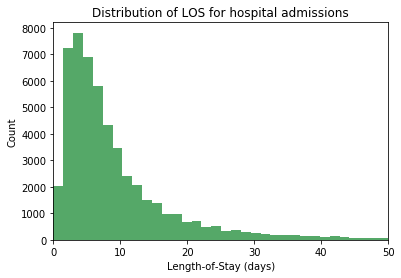

In [18]:
plt.hist(df['LOS'].loc[df['DECEASED'] == 0], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

<a class="anchor" id="Ethnicity"></a>
### 2.1.3 Ethnicity 

Given the large amount of categories in the 'ETHNICITY' series, my aim was to reduce the column to a few categories. Interestly, asians have the lowest median LOS. 

In [19]:
df['ETHNICITY'].value_counts()

WHITE                                                       40939
BLACK/AFRICAN AMERICAN                                       5434
UNKNOWN/NOT SPECIFIED                                        4502
HISPANIC OR LATINO                                           1693
ASIAN                                                        1508
OTHER                                                        1507
UNABLE TO OBTAIN                                              809
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
WHITE - OT

In [20]:
# Compress the number of ethnicity categories
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ETHNICITY'].value_counts()

C:\Users\Satya\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


WHITE                     41268
OTHER/UNKNOWN              7700
BLACK/AFRICAN AMERICAN     5779
HISPANIC/LATINO            2125
ASIAN                      2006
Name: ETHNICITY, dtype: int64

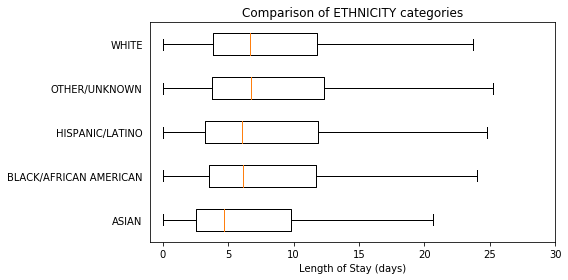

In [21]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

boxplot_los_groupby('ETHNICITY', los_range=(-1, 30))

<a class="anchor" id="Religion"></a>
### 2.1.4 Religion
I thought it was interesting that this was tracked in MIMIC. BUDDHIST, HINDU, and MUSLIM trend with lower LOS medians, but are a very small proportion of the dataset. 

In [22]:
df['RELIGION'].value_counts()

CATHOLIC                  20580
NOT SPECIFIED             11738
UNOBTAINABLE               8242
PROTESTANT QUAKER          7121
JEWISH                     5307
OTHER                      2695
EPISCOPALIAN                771
GREEK ORTHODOX              459
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

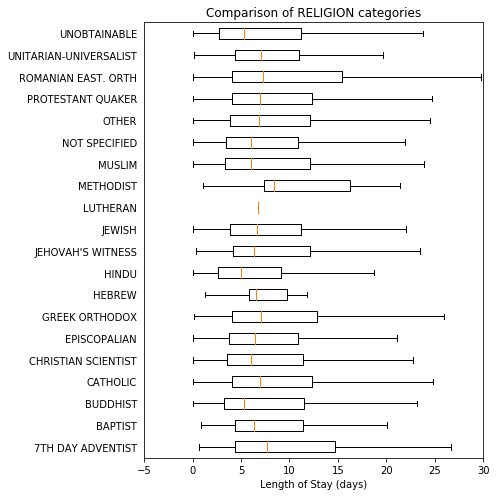

In [23]:
boxplot_los_groupby('RELIGION', los_range=(-5, 30), size=(7, 7))

In [24]:
# Reduce categories to terms of religious or not
# I tested with and without category reduction, with little change in R2 score
df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(df['RELIGION'].value_counts())
print(df['RELIGION'].value_counts()[0]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[1]/len(df['RELIGION']))
print(df['RELIGION'].value_counts()[2]/len(df['RELIGION']))

RELIGIOUS        38898
NOT SPECIFIED    11738
UNOBTAINABLE      8242
Name: RELIGION, dtype: int64
0.6606542341791501
0.1993613913516084
0.13998437446924147


C:\Users\Satya\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


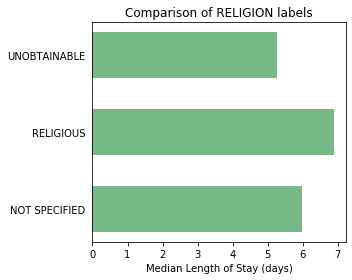

In [25]:
# Look at median LOS for groups
plot_los_groupby('RELIGION', size=(5,4))

<a class="anchor" id="Adm_type"></a>
### 2.1.5 Admission Type

Newborns have the lowest median LOS followed by elective admissions. This is expected since these are often somewhat planned for and with the risks being understood. 

In [26]:
df['ADMISSION_TYPE'].value_counts()

EMERGENCY    41989
NEWBORN       7854
ELECTIVE      7702
URGENT        1333
Name: ADMISSION_TYPE, dtype: int64

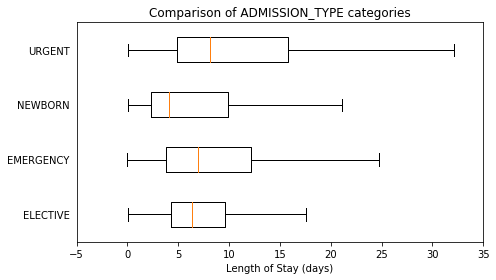

In [27]:
boxplot_los_groupby('ADMISSION_TYPE', los_range=(-5, 35), size=(7, 4))

<a class="anchor" id="Insurance"></a>
### 2.1.6 Insurance

If a patient is 'Self-Pay', typically means they can't or didn't pay. Self-pay patients have the lowest LOS.  

In [28]:
df['INSURANCE'].value_counts()

Medicare      28174
Private       22542
Medicaid       5778
Government     1781
Self Pay        603
Name: INSURANCE, dtype: int64

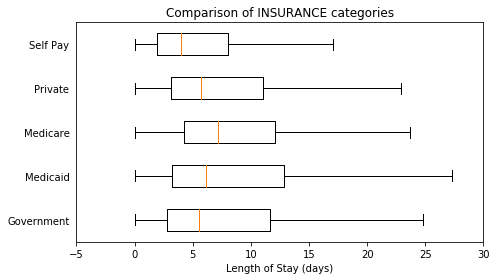

In [29]:
boxplot_los_groupby('INSURANCE', los_range=(-5, 30), size=(7, 4))

<a class="anchor" id="Marital"></a>
### 2.1.7 Marital status

In [30]:
df['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24199
SINGLE               13238
NaN                  10097
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
UNKNOWN (DEFAULT)      343
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [31]:
# Fix NaNs and file under 'UNKNOWN'
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24199
SINGLE               13238
UNKNOWN (DEFAULT)    10440
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

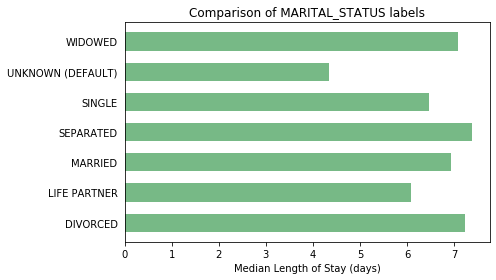

In [32]:
plot_los_groupby('MARITAL_STATUS')

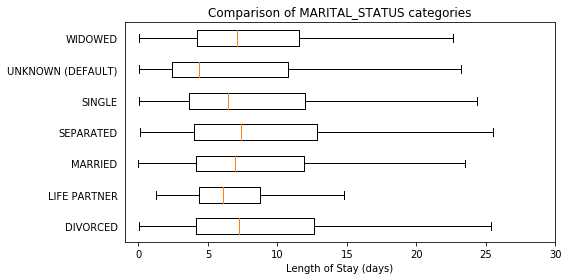

In [33]:
boxplot_los_groupby('MARITAL_STATUS')

<a class="anchor" id="DIAGNOSES_ICD.csv"></a>
## 2.2 DIAGNOSES_ICD.csv Exploration 

This section explore the ICUSTAYS.csv table of the MIMIC-III dataset. 

<a class="anchor" id="ICD_FE"></a>
### 2.2.1 ICD-9 Code Feature Engineering

From [Wiki](https://en.wikipedia.org/wiki/International_Statistical_Classification_of_Diseases_and_Related_Health_Problems#ICD-9): International Classification of Diseases, Clinical Modification (ICD-9-CM) is an adaption created by the U.S. National Center for Health Statistics (NCHS) and used in assigning diagnostic and procedure codes associated with inpatient, outpatient, and physician office utilization in the United States. 

In [34]:
# Imports
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#df_diagcode = pd.read_csv('DIAGNOSES_ICD.csv')
df_diagcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
ROW_ID        651047 non-null int64
SUBJECT_ID    651047 non-null int64
HADM_ID       651047 non-null int64
SEQ_NUM       651000 non-null float64
ICD9_CODE     651000 non-null object
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [35]:
print('There are {} unique ICD9 codes in this dataset.'.format(df_diagcode['ICD9_CODE'].value_counts().count()))

There are 6984 unique ICD9 codes in this dataset.


Because it's not feasible to have 6984 unique values to use as features for predicting LOS, I need to reduce the diagnosis into more general categories. After researching the ICD9 approach, I discovery that they arranged into super categories as the following [(source)](https://en.wikipedia.org/wiki/List_of_ICD-9_codes):
* 001–139: infectious and parasitic diseases
* 140–239: neoplasms
* 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
* 280–289: diseases of the blood and blood-forming organs
* 290–319: mental disorders
* 320–389: diseases of the nervous system and sense organs
* 390–459: diseases of the circulatory system
* 460–519: diseases of the respiratory system
* 520–579: diseases of the digestive system
* 580–629: diseases of the genitourinary system
* 630–679: complications of pregnancy, childbirth, and the puerperium
* 680–709: diseases of the skin and subcutaneous tissue
* 710–739: diseases of the musculoskeletal system and connective tissue
* 740–759: congenital anomalies
* 760–779: certain conditions originating in the perinatal period
* 780–799: symptoms, signs, and ill-defined conditions
* 800–999: injury and poisoning
* E and V codes: external causes of injury and supplemental classification, *using 999 as placeholder even though it overlaps with complications of medical care*

Now the task is to re-code the in terms of these category groups. 

In [36]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['ICD9_CODE']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)

In [37]:
# https://stackoverflow.com/questions/46168450/replace-specific-range-of-values-in-data-frame-pandas
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

In [38]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), 
            num, df_diagcode['recode'])
    
# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

In [39]:
# Verify
df_diagcode.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,recode,cat
0,1297,109,172335,1.0,40301,6,circulatory
1,1298,109,172335,2.0,486,7,respiratory
2,1299,109,172335,3.0,58281,9,genitourinary
3,1300,109,172335,4.0,5855,9,genitourinary
4,1301,109,172335,5.0,4254,6,circulatory


For each admission, there could be (and usually is) more than one diagnosis. Often, there are more than 1 diagnoses for 1 category. Therefore, I need to create a dummy matrix that highlights all the diagnoses for each admission. This should not be done on the SUBJECT_ID since each patient could have different diagnoses for each admission. 

In [40]:
# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('HADM_ID')['cat'].apply(list).reset_index()
hadm_list.head()

,HADM_ID,cat
0,100001,"[endocrine, nervous, genitourinary, digestive,..."
1,100003,"[digestive, blood, infectious, digestive, circ..."
2,100006,"[respiratory, respiratory, respiratory, neopla..."
3,100007,"[digestive, digestive, injury, respiratory, ci..."
4,100009,"[circulatory, injury, circulatory, endocrine, ..."


In [41]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [42]:
# Join back with HADM_ID, will merge with main admissions DF later
hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009


In [43]:
# Merge with main admissions df
df = df.merge(hadm_item, how='inner', on='HADM_ID')

In [44]:
# Verify Merge
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,4,1,0,0,0,1,0,0,0,0
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,1,0,0,0,0,1,0,0,0,0
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,3,0,0,0,1,1,0,1,0,0
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,0,0,0
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,0,0,0


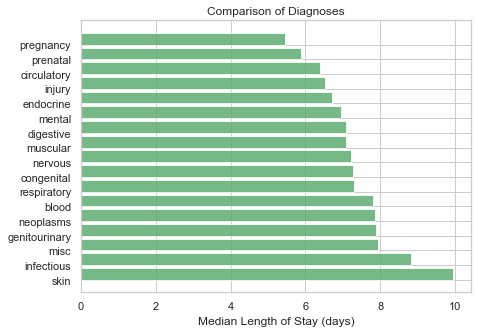

In [45]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(df[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")
#sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

<a class="anchor" id="PATIENTS.csv"></a>
## 2.3 Patients.csv Exploration 

The PATIENTS table provides age and gender information. To protect identity, a patient’s age is given by the difference between their 'DOB' date of birth and the date of their first admission. Therefore, subsequent admissions for the same patient need to be ignored in the calculation. The only things that need to be done with this table are to extract the DOB and gender information and merge them with the admissions dataframe. 

In [46]:
df_pat.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [47]:
df_pat['GENDER'].value_counts()

M    26121
F    20399
Name: GENDER, dtype: int64

In [48]:
# Convert to datetime type
df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])

In [49]:
df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
df_pat.head()

,SUBJECT_ID,DOB,GENDER
0,249,2075-03-13,F
1,250,2164-12-27,F
2,251,2090-03-15,M
3,252,2078-03-06,M
4,253,2089-11-26,F


In [50]:
df = df.merge(df_pat, how='inner', on='SUBJECT_ID')

<a class="anchor" id="Age_FE"></a>
### 2.3.1 Age (Feature Engineering)

Now that the admissions dataFrame has DOB information, age can be calculated. 

In [51]:
# Find the first admission time for each patient
df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df_age_min.head()

,SUBJECT_ID,ADMIT_MIN
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


In [52]:
df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [53]:
# Verify merge
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN
0,22,165315,2196-04-09 12:26:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,...,0,0,1,0,0,0,0,2131-05-07,F,2196-04-09 12:26:00
1,23,152223,2153-09-03 07:15:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,...,0,0,1,0,0,0,0,2082-07-17,M,2153-09-03 07:15:00
2,23,124321,2157-10-18 19:34:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,...,0,1,1,0,1,0,0,2082-07-17,M,2153-09-03 07:15:00
3,24,161859,2139-06-06 16:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,...,0,0,0,0,0,0,0,2100-05-31,M,2139-06-06 16:14:00
4,25,129635,2160-11-02 02:06:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,...,0,0,0,0,0,0,0,2101-11-21,M,2160-11-02 02:06:00


In [54]:
df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN']).dt.date
df['DOB'] = pd.to_datetime(df['DOB']).dt.date
df['age'] = df['ADMIT_MIN']-df['DOB']
df['age'] = df['age'].apply(lambda x: x.days)
df['age'] = df['age']//365

In [55]:
# df = df[df['age']<100]

In [56]:
# df['age'] = np.where(df['age'] < 0, 90, df['age'])
df['age'].isnull().sum()

0

In [57]:
df = df[df['age']>0]
df = df[df['age']<100]

In [58]:
len(df[df['age']<0])

0

In [59]:
len(df[df['age']>100])

0

In [60]:
len(df)

48167

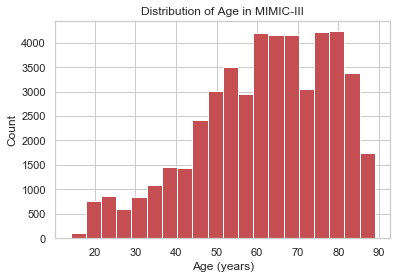

In [61]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

(1, 50)

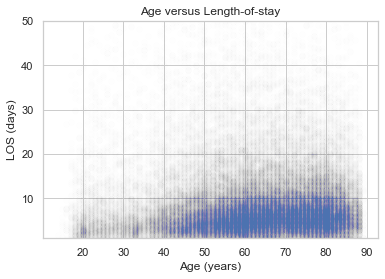

In [62]:
plt.scatter(df['age'], df['LOS'], alpha=0.005)
#plt.yscale('sqrt')
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

In [63]:
# https://en.wikipedia.org/wiki/List_of_ICD-9_codes
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]), 
            num, df['age'])
    
age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
df['age'] = df['age'].replace(age_dict)
df.age.value_counts()

senior          31175
middle_adult    12732
young_adult      4260
Name: age, dtype: int64

<a class="anchor" id="Gender"></a>
### 2.3.2 Gender

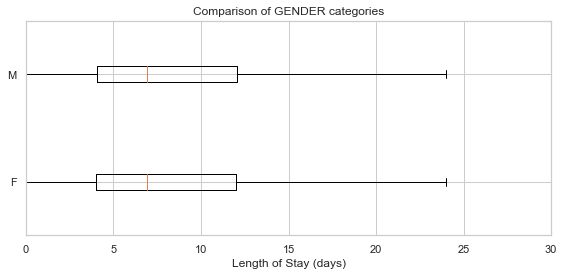

In [64]:
boxplot_los_groupby('GENDER', los_range=(0, 30))
df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

<a class="anchor" id="ICUSTAYS.csv"></a>
## 2.4 ICUSTAYS.csv Exploration

In [65]:
# Intensive Care Unit (ICU) for each admission to hospital
df_icu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
ROW_ID            61532 non-null int64
SUBJECT_ID        61532 non-null int64
HADM_ID           61532 non-null int64
ICUSTAY_ID        61532 non-null int64
DBSOURCE          61532 non-null object
FIRST_CAREUNIT    61532 non-null object
LAST_CAREUNIT     61532 non-null object
FIRST_WARDID      61532 non-null int64
LAST_WARDID       61532 non-null int64
INTIME            61532 non-null object
OUTTIME           61522 non-null object
LOS               61522 non-null float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


In [66]:
df_icu['HADM_ID'].nunique()

57786

In [67]:
df_icu.groupby('FIRST_CAREUNIT').median()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS
FIRST_CAREUNIT,,,,,,,
CCU,29091.5,22964.5,150074.5,249373.5,7.0,7.0,2.19775
CSRU,31002.5,24488.0,150225.0,250492.0,14.0,14.0,2.15290
MICU,33612.5,26489.5,150368.0,250524.0,50.0,50.0,2.09550
NICU,19581.5,15456.5,149206.5,249308.0,56.0,56.0,0.80250
SICU,38089.0,30084.0,149744.0,248649.0,33.0,33.0,2.25220
TSICU,36382.0,28716.0,148915.0,250685.0,14.0,14.0,2.11150


<a class="anchor" id="ICU_FE"></a>
### 2.4.1 ICU (Feature Engineering)

In [68]:
# Based on above statistics, reduce to just ICU and NICU groups
df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [69]:
df_icu['cat'] = df_icu['FIRST_CAREUNIT']
icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_list.head()

,HADM_ID,cat
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [70]:
df_icu['FIRST_CAREUNIT'].value_counts()

ICU     53432
NICU     8100
Name: FIRST_CAREUNIT, dtype: int64

In [71]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
icu_item.head()

,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [72]:
print("Number of admissions to ICU {}.".format(icu_item.ICU.sum()))
print("Number of admissions to NICU {}.".format(icu_item.NICU.sum()))

Number of admissions to ICU 49794.
Number of admissions to NICU 7992.


In [73]:
# Merge ICU data with main dataFrame
df = df.merge(icu_item, how='outer', on='HADM_ID')

In [74]:
# Replace NaNs with 0
df['ICU'].fillna(value=0, inplace=True)
df['NICU'].fillna(value=0, inplace=True)

In [75]:
# Verify NaN fix
print(df.ICU.value_counts(dropna=False))
print(df.NICU.value_counts(dropna=False))

1.0    49794
0.0     9015
Name: ICU, dtype: int64
0.0    50817
1.0     7992
Name: NICU, dtype: int64


<a class="anchor" id="Data-Preprocessing"></a>
# 3. Data Preprocessing

Even after completing the feature engineering for age and ICD-9, there were some loose ends that needed tidying up before the data could be used for the prediction model. First, I ensured that no admissions resulting in death were part the cleaned dataset. I dropped all unused columns and verified that no NaNs existed in the data. For the admission type, insurance type, religion, ethnicity, age, and marital status columns, I performed the Pandas get_dummies command to convert these categorical variables into dummy/indicator variables. The final DataFrame size resulted in 48 feature columns and 1 target column with an entry count of 53,104.

In [76]:
# Look at what is no longer needed in the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58809 entries, 0 to 58808
Data columns (total 38 columns):
SUBJECT_ID            48167 non-null float64
HADM_ID               58809 non-null int64
ADMITTIME             48167 non-null datetime64[ns]
DEATHTIME             5172 non-null object
ADMISSION_TYPE        48167 non-null object
ADMISSION_LOCATION    48167 non-null object
DISCHARGE_LOCATION    48167 non-null object
INSURANCE             48167 non-null object
LANGUAGE              31535 non-null object
RELIGION              48167 non-null object
MARITAL_STATUS        48167 non-null object
ETHNICITY             48167 non-null object
DIAGNOSIS             48145 non-null object
LOS                   48167 non-null float64
DECEASED              48167 non-null float64
blood                 48167 non-null float64
circulatory           48167 non-null float64
congenital            48167 non-null float64
digestive             48167 non-null float64
endocrine             48167 non-null float

In [77]:
# Remove deceased persons as they will skew LOS result
df = df[df['DECEASED'] == 0]

# Remove LOS with negative number, likely entry form error
df = df[df['LOS'] > 0]

In [78]:
# Drop unused or no longer needed columns
df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS', 'DECEASED',  'DEATHTIME'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42995 entries, 0 to 48166
Data columns (total 27 columns):
ADMISSION_TYPE    42995 non-null object
INSURANCE         42995 non-null object
RELIGION          42995 non-null object
MARITAL_STATUS    42995 non-null object
ETHNICITY         42995 non-null object
LOS               42995 non-null float64
blood             42995 non-null float64
circulatory       42995 non-null float64
congenital        42995 non-null float64
digestive         42995 non-null float64
endocrine         42995 non-null float64
genitourinary     42995 non-null float64
infectious        42995 non-null float64
injury            42995 non-null float64
mental            42995 non-null float64
misc              42995 non-null float64
muscular          42995 non-null float64
neoplasms         42995 non-null float64
nervous           42995 non-null float64
pregnancy         42995 non-null float64
prenatal          42995 non-null float64
respiratory       42995 non-null fl

In [79]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR', 'RELIGION']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS', 'RELIGION']
df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42995 entries, 0 to 48166
Data columns (total 50 columns):
LOS                           42995 non-null float64
blood                         42995 non-null float64
circulatory                   42995 non-null float64
congenital                    42995 non-null float64
digestive                     42995 non-null float64
endocrine                     42995 non-null float64
genitourinary                 42995 non-null float64
infectious                    42995 non-null float64
injury                        42995 non-null float64
mental                        42995 non-null float64
misc                          42995 non-null float64
muscular                      42995 non-null float64
neoplasms                     42995 non-null float64
nervous                       42995 non-null float64
pregnancy                     42995 non-null float64
prenatal                      42995 non-null float64
respiratory                   42995 non-nul

In [80]:
# Verify
df.head()

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED,RELIGION_NOT SPECIFIED,RELIGION_RELIGIOUS,RELIGION_UNOBTAINABLE
0,1.144444,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,...,0,0,1,0,0,0,0,0,0,1
1,5.496528,0.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,6.768056,0.0,2.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,...,0,0,1,0,0,0,0,0,1,0
3,2.856944,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
4,3.534028,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1


<a class="anchor" id="Data-cleanup"></a>
### 3.1 Data Cleanup Function
The `mimic_los_cleanup` performs all of the above data cleanup and feature engineering steps. 

In [81]:
def mimic_los_cleanup(adm_csv='ADMISSIONS.csv', patients_csv='PATIENTS.csv',
                      diagcode_csv='DIAGNOSES_ICD.csv', icu_csv='ICUSTAYS.csv',
                      verbose=True):
    '''
    This function take 4 csv files from the MIMIC-III database, converts them to
    DataFrames for cleanup and feature engineering for use in a Length-of-Stay
    regression model such as the sklearn GradientBoostingRegressor. 
    
    INPUT:
    adm_csv - Primary Admissions information
    patients_csv - Patient specific info such as gender and DOB
    diagcode_csv - ICD9 Diagnosis for each admission to hospital
    icu_csv - Intensive Care Unit (ICU) data for each admission 
    
    OUTPUT:
    df - clean DataFrame for use in an regression model
    actual_median_los - Median LOS for all admissions 
    actual_mean_los - Average LOS for all admissions
    '''
    
    # Import CSV tables
    df = pd.read_csv(adm_csv)
    df_pat = pd.read_csv(patients_csv)
    df_diagcode = pd.read_csv(diagcode_csv)
    df_icu = pd.read_csv(icu_csv)
    if verbose: 
        print('(1/5) Completed .csv imports')
        
    # Feature Engineering for Length of Stay (LOS) target variable
    # Convert admission and discharge times to datatime type
    df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
    df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME'])
    # Convert timedelta type into float 'days', 86400 seconds in a day
    df['LOS'] = (df['DISCHTIME'] - df['ADMITTIME']).dt.total_seconds()/86400
    
    # Drop columns that are not needed for next steps
    df.drop(columns=['DISCHTIME', 'ROW_ID', 
                    'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                    'HAS_CHARTEVENTS_DATA'], inplace=True)
    
    # Track patients who died at the hospital by admission event
    df['DECEASED'] = df['DEATHTIME'].notnull().map({True:1, False:0})
    
    # Hospital LOS metrics
    actual_mean_los = df['LOS'].loc[df['DECEASED'] == 0].mean() 
    actual_median_los = df['LOS'].loc[df['DECEASED'] == 0].median() 
    
    # Compress the number of ethnicity categories
    df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
    df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
    df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
    df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
    df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                             'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
    df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'

    # Reduce categories to terms of religious or not
    df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

    # Re-categorize NaNs into 'Unknown'
    df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
    
    if verbose: 
        print('(2/5) Completed ADMISSIONS.csv cleanup and feature engineering.')
        
    # Feature Engineering for ICD9 code categories
    # Filter out E and V codes since processing will be done on the numeric first 3 values
    df_diagcode['recode'] = df_diagcode['ICD9_CODE']
    df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
    df_diagcode['recode'].fillna(value='999', inplace=True)
    df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
    df_diagcode['recode'] = df_diagcode['recode'].astype(int)
    
    # ICD-9 Main Category ranges
    icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
                   (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
                   (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

    # Associated category names
    diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
                 4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
                 8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
                 12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
                 16: 'injury', 17: 'misc'}

    # Re-code in terms of integer
    for num, cat_range in enumerate(icd9_ranges):
        df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), 
                num, df_diagcode['recode'])

    # Convert integer to category name using diag_dict
    df_diagcode['recode'] = df_diagcode['recode']
    df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)
    
    # Create list of diagnoses for each admission
    hadm_list = df_diagcode.groupby('HADM_ID')['cat'].apply(list).reset_index()
    
    # Convert diagnoses list into hospital admission-item matrix
    hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
    
    # Join back with HADM_ID, will merge with main admissions DF later
    hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")

    # Merge with main admissions df
    df = df.merge(hadm_item, how='inner', on='HADM_ID')
    
    if verbose: 
        print('(3/5) Completed DIAGNOSES_ICD.csv cleanup and feature engineering.')
    
    # Feature Engineering for Age and Gender
    # Convert to datetime type
    df_pat['DOB'] = pd.to_datetime(df_pat['DOB'])
    df_pat = df_pat[['SUBJECT_ID', 'DOB', 'GENDER']]
    df = df.merge(df_pat, how='inner', on='SUBJECT_ID')
    
    # Find the first admission time for each patient
    df_age_min = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
    df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
    df = df.merge(df_age_min, how='outer', on='SUBJECT_ID')
    
    # Age is decode by finding the difference in admission date and date of birth
    df['ADMIT_MIN'] = pd.to_datetime(df['ADMIT_MIN']).dt.date
    df['DOB'] = pd.to_datetime(df['DOB']).dt.date
    df['age'] = df['ADMIT_MIN']-df['DOB']
    df['age'] = df['age'].apply(lambda x: x.days)
    df['age'] = df['age']//365
    
    df = df[df['age']<=100]
    df = df[df['age']>=0]
#     df['age'] = np.where(df['age'] < 0, 90, df['age'])
    
    # Create age categories
    age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
    for num, cat_range in enumerate(age_ranges):
        df['age'] = np.where(df['age'].between(cat_range[0],cat_range[1]), 
                num, df['age'])
    age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
    df['age'] = df['age'].replace(age_dict)
    
    # Re-map Gender to boolean type
    df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)
    
    if verbose: 
        print('(4/5) Completed PATIENT.csv cleanup and feature engineering.')
    
    # Feature engineering for Intensive Care Unit (ICU) category
    # Reduce ICU categories to just ICU or NICU
    df_icu['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)
    df_icu['cat'] = df_icu['FIRST_CAREUNIT']
    icu_list = df_icu.groupby('HADM_ID')['cat'].apply(list).reset_index()
    icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
    icu_item[icu_item >= 1] = 1
    icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
    df = df.merge(icu_item, how='outer', on='HADM_ID')
    
    # Cleanup NaNs
    df['ICU'].fillna(value=0, inplace=True)
    df['NICU'].fillna(value=0, inplace=True)
    
    if verbose: 
        print('(5/5) Completed ICUSTAYS.csv cleanup and feature engineering.')
        
    # Remove deceased persons as they will skew LOS result
    df = df[df['DECEASED'] == 0]

    # Remove LOS with negative number, likely entry form error
    df = df[df['LOS'] > 0]    
    
    # Drop unused columns, e.g. not used to predict LOS
    df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_LOCATION',
                'DISCHARGE_LOCATION', 'LANGUAGE', 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS', 'DECEASED', 'DEATHTIME'], inplace=True)
    
    prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR']
    dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
                 'ETHNICITY', 'age', 'MARITAL_STATUS']
    df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols)
    
    if verbose: 
        print('Data Preprocessing complete.')
    
    return df, actual_median_los, actual_mean_los

df_clean, actual_median_los, actual_mean_los = mimic_los_cleanup(adm_csv='data/ADMISSIONS.csv', 
                                                                 patients_csv='data/PATIENTS.csv',
                                                                 diagcode_csv='data/DIAGNOSES_ICD.csv', 
                                                                 icu_csv='data/ICUSTAYS.csv')

(1/5) Completed .csv imports


C:\Users\Satya\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(2/5) Completed ADMISSIONS.csv cleanup and feature engineering.
(3/5) Completed DIAGNOSES_ICD.csv cleanup and feature engineering.
(4/5) Completed PATIENT.csv cleanup and feature engineering.
(5/5) Completed ICUSTAYS.csv cleanup and feature engineering.
Data Preprocessing complete.


In [82]:
len(df_clean)

51037

In [83]:
# Verify output of cleaning function
df_clean.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51037 entries, 0 to 56359
Data columns (total 49 columns):
LOS                           51037 non-null float64
blood                         51037 non-null float64
circulatory                   51037 non-null float64
congenital                    51037 non-null float64
digestive                     51037 non-null float64
endocrine                     51037 non-null float64
genitourinary                 51037 non-null float64
infectious                    51037 non-null float64
injury                        51037 non-null float64
mental                        51037 non-null float64
misc                          51037 non-null float64
muscular                      51037 non-null float64
neoplasms                     51037 non-null float64
nervous                       51037 non-null float64
pregnancy                     51037 non-null float64
prenatal                      51037 non-null float64
respiratory                   51037 non-nul

In [84]:
# Check for any remaining NaNs
df_clean.isnull().values.sum()

0

In [85]:
df_clean.to_csv('data.csv',index=False)

#### <a class="anchor" id="Prediction"></a>
# 4. Length-of-Stay Prediction Model

In this section I'll walkthrough the implementation and selection of the supervised learning prediction model using the Scikit-Learn machine learning library.

<a class="anchor" id="Implementation"></a>
## 4.1 Model Implementation

To implement the prediction model, I split the LOS target variable and features into training and test sets at an 80:20 ratio using the scikit-learn train_test_split function. Using the training set, I'll fit five different regression models (from the scikit-learn library) using default settings to see what the R2 score comparison looked like.

In [86]:
# Target Variable (Length-of-Stay)
LOS = df_clean['LOS'].values
# Prediction Features
features = df_clean.drop(columns=['LOS'])

In [87]:
df_clean.columns

Index(['LOS', 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine',
       'genitourinary', 'infectious', 'injury', 'mental', 'misc', 'muscular',
       'neoplasms', 'nervous', 'pregnancy', 'prenatal', 'respiratory', 'skin',
       'GENDER', 'ICU', 'NICU', 'ADM_ELECTIVE', 'ADM_EMERGENCY', 'ADM_NEWBORN',
       'ADM_URGENT', 'INS_Government', 'INS_Medicaid', 'INS_Medicare',
       'INS_Private', 'INS_Self Pay', 'REL_NOT SPECIFIED', 'REL_RELIGIOUS',
       'REL_UNOBTAINABLE', 'ETH_ASIAN', 'ETH_BLACK/AFRICAN AMERICAN',
       'ETH_HISPANIC/LATINO', 'ETH_OTHER/UNKNOWN', 'ETH_WHITE',
       'AGE_middle_adult', 'AGE_newborn', 'AGE_senior', 'AGE_young_adult',
       'MAR_DIVORCED', 'MAR_LIFE PARTNER', 'MAR_MARRIED', 'MAR_SEPARATED',
       'MAR_SINGLE', 'MAR_UNKNOWN (DEFAULT)', 'MAR_WIDOWED'],
      dtype='object')

In [88]:
# Looking at the final clean data
df_clean.head()

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,AGE_newborn,AGE_senior,AGE_young_adult,MAR_DIVORCED,MAR_LIFE PARTNER,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED
0,1.144444,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,...,0,1,0,0,0,1,0,0,0,0
1,5.496528,0.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,6.768056,0.0,2.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,2.856944,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,3.534028,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0


In [89]:
len(df_clean)

51037

In [90]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 40829 samples.
Testing set has 10208 samples.


In [91]:
# Regression models for comparison
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

SGDRegressor done.
GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.


C:\Users\Satya\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor done.


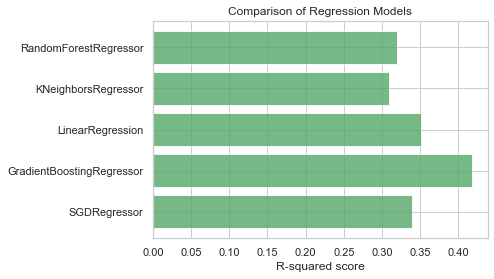

In [92]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
fig.savefig('images/compare_models.png', bbox_inches = 'tight')

The GradientBoostingRegressor took the win with an R2 score of ~37% so I decided to focus on refining this particular model. Because of past success with the RandomForestRegressor, I played with that model’s parameters but was never able to exceed the GradientBoostingRegressor score.

In [93]:
# GradientBoostingRegressor will be used as the LOS prediction model
reg_model = GradientBoostingRegressor(random_state=0)   
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined)) 

R2 score is: 0.417283


## <a class="anchor" id="Refinement"></a>
## 4.2 Model Refinement 

The GradientBoostingRegressor performed well versus the other regression model. To refine the GradientBoostingRegressor model, I used the GridSearchCV function from scikit-learn to test out various permutations of parameters such as n_estimators, max_depth, and loss. The best estimator result from GridSearchCV was n_estimators=200, max_depth=4, and loss=ls.

In [94]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 42)

# Set the parameters by cross-validation
#tuned_parameters = [{'n_estimators': [100, 200, 300],
#                     'max_depth' : [2, 3, 4],
#                     'loss': ['ls', 'lad', 'huber']}]
tuned_parameters = [{'n_estimators': [200, 300],
                     'max_depth' : [3, 4],
                     'loss': ['ls', 'lad']}]

# create and fit a ridge regression model, testing each alpha
reg_model = GradientBoostingRegressor()  
grid = GridSearchCV(reg_model, tuned_parameters)
grid.fit(X_train, y_train)
reg_model_optimized = grid.best_estimator_

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

C:\Users\Satya\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.40397031698389263
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [95]:
#reg_model = GradientBoostingRegressor(n_estimators = 200, max_depth=4, random_state=0)   
#reg_model.fit(X_train, y_train)
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized)) 

Optimized R2 score is: 0.409355


In [96]:
print('Model refinement improved R2 score by {:.4f}'.format(r2_optimized-r2_not_refined))

Model refinement improved R2 score by -0.0079


<a class="anchor" id="Results"></a>
# 5. Results

Before looking at the RMSE benchmark, I wanted to investigate what features were most important in predicting hospital length-of-stay when using the gradient boosting regression model. Diagnoses related to prenatal issues have the highest feature importance coefficient followed by respiratory and injury. As I alluded to earlier, the ICD-9 diagnoses categories are by far the most important features. In fact, in the top 20 top features, only emergency admission type, gender, and Medicaid insurance showed any importance outside of diagnoses groups.

In [97]:
# https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_imp = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
prenatal,0.427686
respiratory,0.112379
infectious,0.107225
nervous,0.087185
digestive,0.077290
injury,0.030345
skin,0.022290
genitourinary,0.021874
congenital,0.019906
ADM_EMERGENCY,0.016068


In [98]:
feature_imp.index[0:10].tolist()

['prenatal',
 'respiratory',
 'infectious',
 'nervous',
 'digestive',
 'injury',
 'skin',
 'genitourinary',
 'congenital',
 'ADM_EMERGENCY']

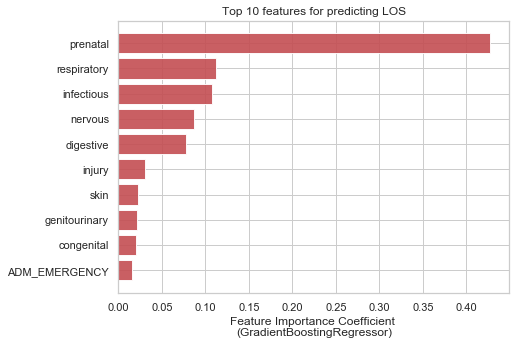

In [99]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10], 
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top 10 features for predicting LOS")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()
fig.savefig('images/feature_importance.png', bbox_inches = 'tight')

In [113]:
i=50
LOS_actual = y_test[i:i+20]
LOS_predict = y_test_preds[i:i+20]

In [114]:
sum(abs(LOS_actual-LOS_predict))/len(LOS_actual)

9.34207540618386

In [115]:
len(y_test_preds)==len(y_test)

True

C:\Users\Satya\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  del sys.path[0]
C:\Users\Satya\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  


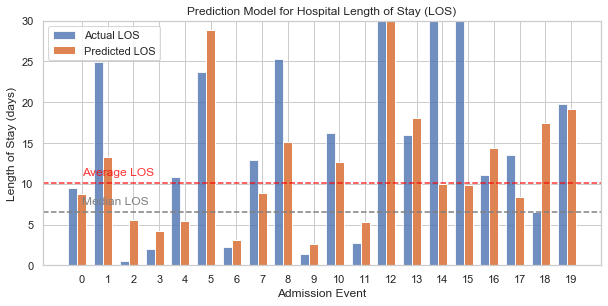

In [116]:
fig, ax = plt.subplots(figsize=(10, 4.5))

# https://matplotlib.org/examples/api/barchart_demo.html
ind = np.arange(0,20)
pad = 0.15
width = 0.35
set_actual = ax.bar(pad+ind, LOS_actual, width, color='#4c72b0', alpha=0.8)
set_predict = ax.bar(pad+ind+width, LOS_predict, width, color='#dd8452')

ax.set_ylabel('Length of Stay (days)')
ax.set_xlabel('Admission Event')
ax.set_title('Prediction Model for Hospital Length of Stay (LOS)')
ax.text(0.5, 11, 'Average LOS', fontdict=None, withdash=False, color='red', alpha=0.8)
ax.text(0.5, 7.5, 'Median LOS', fontdict=None, withdash=False, color='gray')
ax.set_xticks(pad + ind + width)
ax.set_ylim(0, 30)
ax.set_xticklabels(list(range(20)))
ax.axhline(y=actual_median_los, xmin=0, xmax=20, ls='--', color='gray')
ax.axhline(y=actual_mean_los, xmin=0, xmax=20, ls='--', color='red', alpha=0.8)
ax.legend( (set_actual, set_predict), ('Actual LOS', 'Predicted LOS'), 
          loc='upper left')
ax.tick_params(bottom=False, top=False, right=False)

While the RMSE trend is promising, I also wanted to evaluate the model from a few other perspectives. The following figure takes the first 20 admissions from the test set and directly compares the actual, predicted (gradient boosting model), average, and median LOS values. This gives a more convoluted picture of the prediction model; in some admissions, it predicts well but not as well in others.

In [117]:
actual_median_los = np.median(y_test)
actual_avg_los = np.mean(y_test)

In [118]:
#y_test_preds = reg_model.predict(X_test)

ml_count, md_count, avg_count  = 0, 0, 0
ml_days, md_days, avg_days  = 0, 0, 0
ml_days_rms, md_days_rms, avg_days_rms  = 0, 0, 0

for i in range(y_test_preds.shape[0]):
    ml_model = abs(y_test_preds[i] - y_test[i])
    median_model = abs(actual_median_los - y_test[i])
    average_model = abs(actual_avg_los - y_test[i])
    
    ml_days += ml_model
    md_days += median_model
    avg_days += average_model
    
    ml_model_rms = (y_test_preds[i] - y_test[i])**2
    median_model_rms = (actual_median_los - y_test[i])**2
    average_model_rms = (actual_avg_los - y_test[i])**2
    
    ml_days_rms += ml_model_rms
    md_days_rms += median_model_rms
    avg_days_rms += average_model_rms

print("Prediction Model days {}".format(ml_days/y_test_preds.shape[0]))
print("Median Model days {}".format(md_days/y_test_preds.shape[0]))
print("Average Model days {}".format(avg_days/y_test_preds.shape[0]))

print("Prediction Model RMS {}".format((ml_days_rms**0.5)/y_test_preds.shape[0]))
print("Median Model RMS {}".format((md_days_rms**0.5)/y_test_preds.shape[0]))
print("Average Model RMS {}".format((avg_days_rms**0.5)/y_test_preds.shape[0]))

Prediction Model days 5.343054127082039
Median Model days 6.290070083921124
Average Model days 7.0497419145010065
Prediction Model RMS 0.08974748345983889
Median Model RMS 0.1218337741756018
Average Model RMS 0.11677744476688794


In [125]:
sum(((y_test_preds-y_test)**2))/len(y_test)

82.22146691751433

In the metrics section, I stated that the RMSE would be used to compare the prediction model versus the industry standard average and median LOS metrics. The gradient boosting model RMSE is better by more than 24% (percent difference) versus the constant average or median models.

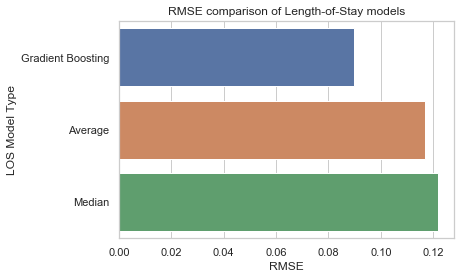

In [119]:
# RMSE plot for writeup
data = pd.DataFrame({'RMSE': [(ml_days_rms**0.5)/y_test_preds.shape[0], 
                             (avg_days_rms**0.5)/y_test_preds.shape[0],
                             (md_days_rms**0.5)/y_test_preds.shape[0]],
                     'LOS Model Type': ['Gradient Boosting', 'Average', 'Median'] })

fig, ax = plt.subplots()
ax = sns.barplot(x='RMSE', y='LOS Model Type', data=data)
ax.set_title('RMSE comparison of Length-of-Stay models')
ax.tick_params(top=False, left=False, right=False)

fig.savefig('images/rms_comparison.png', bbox_inches = 'tight')

The final way I wanted to look at the model was to plot the proportion of accurate predictions in the test set versus an allowed margin of error. Other studies qualify a LOS prediction as correct if it falls within a certain margin of error. It follows that as the margin of error allowance increases, so should the proportion of accurate predictions for all models. The gradient boosting prediction model performs better than the other constant models across the margin of error range up to 50%.

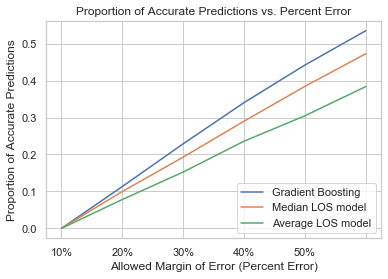

In [120]:
# Calculate Proportion of 'accurate' prediction as a function of allowed margin of error
reg_array = []
median_array = []
average_array = []

for i in list(range(6)):
    reg_count, median_count, average_count = 0, 0, 0
    
    for j in range(y_test_preds.shape[0]):
        # Percent Difference
        reg_model = (y_test_preds[j] - y_test[j])/y_test[j]
        median_model = (actual_median_los - y_test[j])/y_test[j]
        average_model = (actual_avg_los - y_test[j])/y_test[j]
        if abs(reg_model) < i/10:
            reg_count += 1
        if abs(median_model) < i/10:
            median_count += 1
        if abs(average_model) < i/10:
            average_count += 1
            
    reg_array.append((reg_count/y_test_preds.shape[0]))
    median_array.append((median_count/y_test_preds.shape[0]))
    average_array.append((average_count/y_test_preds.shape[0]))

# Plot proportion of 'accurate' prediction as a function of allowed margin of error  
fig, ax = plt.subplots()
ax.plot(reg_array, label='Gradient Boosting')
ax.plot(median_array, label='Median LOS model')
ax.plot(average_array, label='Average LOS model')
ax.set_title('Proportion of Accurate Predictions vs. Percent Error')
ax.set_xlabel('Allowed Margin of Error (Percent Error)')
ax.set_ylabel('Proportion of Accurate Predictions')
ax.set_xticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
ax.legend(loc='lower right');
ax.tick_params(top=False, right=False)
fig.savefig('images/rms_comparison.png', bbox_inches = 'tight')

<a class="anchor" id="Conclusion"></a>
# 6. Conclusion

The MIMIC database offered surprisingly good depth and detail related to medical admissions which enabled me to create a hospital length-of-stay prediction model that considered a lot of interesting input features. The most surprising aspect of this work was how the patient ICD-9 diagnoses played a more important role than age when predicting the length-of-stay. By far, the most challenging aspect of this project was the feature engineering of the ICD-9 diagnoses into a more practical and interpretable form of supercategories. However, therein also lies the most obvious area for future improvement. Given that the diagnoses have such a strong feature importance, it would be worth evaluating whether additional subdividing of the primary ICD-9 categories would yield a better prediction model. My theory is that the prediction model would become more accurate (lower RMSE) with this optimization, so long as there were enough admission records in the dataset for the sub-category diagnoses model training.

## Acknowledgments

MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available from: http://www.nature.com/articles/sdata201635

I found these resources particularly helpful for this project: 
- https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
- https://matplotlib.org/examples/api/barchart_demo.html
- https://stackoverflow.com/questions/46168450/replace-specific-range-of-values-in-data-frame-pandas
- https://en.wikipedia.org/wiki/Root-mean-square_deviation
- https://en.wikipedia.org/wiki/Coefficient_of_determination
- https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/
- https://www.healthcatalyst.com/success_stories/reducing-length-of-stay-in-hospital
- http://bok.ahima.org/Pages/Long%20Term%20Care%20Guidelines%20TOC/Practice%20Guidelines/Reporting